In [1]:
#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import fileinput
import re

from io import StringIO
from sklearn.preprocessing import MinMaxScaler

import ipywidgets as widgets
from ipywidgets import interact, IntRangeSlider, Layout, fixed

# Data Transformation and Features Engineering Section

In [2]:
train_file_path = "Data/PM_train.txt"
test_file_path = "Data/PM_test.txt"
colnames = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7",
           "s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

In [3]:
def move_col_last(df,col_name):
  return pd.concat([df.drop(col_name,axis=1),df[col_name]], axis=1)

def move_col_first(df,col_name):
  return pd.concat([df[col_name],df.drop(col_name,axis=1)], axis=1)

def transfer_data(file_path,col_names):
  # user defined variables to set the windows for classifcation
  w1 = 30
  w0 = 15
  # window size (window_size>=2),  most recent sensor values
  window_size = 5
  
  # read in the file
  with open(file_path, 'r') as f:
    filedata = f.read()
  
  # remove white space from the end of line
  filedata = re.sub('\s*$', '',filedata,flags = re.M)
  
  # filedata is a string that pretends to be a file input
  file_as_string = StringIO(filedata)

  dataset = pd.read_table(file_as_string,sep=" ",names=colnames)
  
  # get the maximum cycle number for each id
  d1 = dataset.groupby(["id"])["cycle"].max().to_frame()
  d1.columns = ['max']

  # add column with the name 'id' (just copy the index)
  d1['id'] = d1.index
  d2 = pd.merge(dataset, d1, on='id')
  
  # generate the column RUL based on the values of columns "max" and "cycle"
  d2['RUL'] = d2['max'] - d2['cycle']

  # exclude column "max" from the data frame
  d2 = d2.drop('max', 1)

  # genearte label1 and label2
  dataset = d2
  dataset['label1'] = np.where(d2['RUL'] <= w1, 1, 0)
  dataset['label2'] = np.where(d2['RUL'] <= w0, 2, (np.where(d2['RUL'] <= w1,1,0)))
  
  # exclude comuns id, cycle, setting1,setting2,setting3, and last 3 columns
  # only the 21 sensor columns are kept in the data frame
  n_pre_sensor_columns = 5 # id, cycle, setting1,setting2,setting3
  n_after_sensor_columns = 3 #RUL, label1, label2
  n_col = len(dataset.columns)

  data = dataset[dataset.columns[n_pre_sensor_columns:n_col - n_after_sensor_columns]]
  n_sensor=len(data.columns)

  ids = dataset.id.unique()
  n_id = len(ids) # 100

  a = ["a" + str(i) for i in range(1,n_sensor+1)] # average
  sd = ["sd" + str(i) for i in range(1,n_sensor+1)] # standard deviation

  df = None
  for i in range(1,n_id+1):
    # get the subset of the data that only contains the sensor columns for the id i
    subset_rolling_mean = data[dataset.id==i].rolling(window_size,axis=0,min_periods=1).mean()
    subset_rolling_mean.columns = a
    subset_rolling_std = data[dataset.id==i].rolling(window_size,axis=0,min_periods=1).std().fillna(0)
    subset_rolling_std.columns = sd
    subset = pd.concat([subset_rolling_mean,subset_rolling_std], axis=1)
    df_tmp = pd.concat([dataset[dataset.id == i],subset], axis=1)
    df_tmp = move_col_last(df_tmp,['RUL', 'label1','label2'])

    if df is None:
      df = df_tmp
    else:
      df = df.append(df_tmp,ignore_index=True)
      
  # Exclude column names: 'id','RUL','label1','label2'
  X = df.drop(['id','RUL','label1','label2'], 1)
  y = df['RUL']
  
  scaler = MinMaxScaler()
  X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

  
  # X = X.dropna(axis=1)
  
  # Delete all columns that contain only zeros
  # X = X.loc[:, (df != 0).any(axis=0)]

  return X,y.as_matrix()

In [4]:
X, y = transfer_data(train_file_path,colnames)
Xt, yt = transfer_data(test_file_path,colnames)

# Training section

In [5]:
from sklearn.tree import DecisionTreeRegressor
DecisionTree_regr = DecisionTreeRegressor(max_leaf_nodes=2000,max_depth=32)
DecisionTree_regr.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=32, max_features=None,
           max_leaf_nodes=2000, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [6]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
Bagging_regr = BaggingRegressor(DecisionTreeRegressor(max_depth=32,min_samples_split=128),n_estimators=8)
Bagging_regr.fit(X,y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=32, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=128, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=8, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [7]:
from sklearn import linear_model
Lasso_regr = linear_model.Lasso(alpha =.1)
Lasso_regr.fit(X,y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
from sklearn import neural_network
NeuralNetwork_regr = neural_network.MLPRegressor(alpha=.1,max_iter=400,hidden_layer_sizes=(50,),solver='lbfgs',random_state=1)
NeuralNetwork_regr.fit(X,y)

MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

# Charts  Section

## Charting functions

In [9]:
RangeSlider = widgets.IntRangeSlider(
    value=[8311,8391],
    min=1,
    max=len(Xt),
    step=10,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    height=3,
    layout=Layout(width='90%', height='50px'),
)

def scaler(arr):
  scaler = MinMaxScaler()
  return pd.DataFrame(scaler.fit_transform(pd.DataFrame(arr)))

def Y_ploter(Range,Y):
  start, end = Range
  range_len = end-start
  
  plt.figure(figsize=(13,10))
  
  # pick colors
  colors = cm.rainbow(np.linspace(0, 1, len(Y)))

  for y,color in zip(Y.items(),colors):
    plt.scatter(np.arange(start, end, 1),y[1][start:end], c=color, s=30/(range_len/80),alpha=0.5, label=y[0])

  plt.grid()
  plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
  plt.ylabel("GT Cycles and Predicted Cycles")
  plt.title(" vs ".join([s for s in Y.keys()]))
  plt.legend()
  plt.show()

def general_data_ploter(Range,Xs,y,scale_y):
  start, end = Range
  range_len = end-start
  
  plt.figure(figsize=(13,10))
  
  # pick colors
  colors = cm.rainbow(np.linspace(0, 1, len(Xs)))
  
  for X,color in zip(Xs,colors):
    # Get label
    label = pd.DataFrame(X).columns[0]
    if(label == 0):
      label = 'y'
    plt.scatter(np.arange(start, end, 1),X[start:end], c=color, s=30/(range_len/80),alpha=0.5, label=label)

  if(scale_y):
    y = scaler(y)

  plt.grid()
  plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
  plt.ylabel("Cycles and sensors values (Scalled)")
  plt.title("Scalled Data and Cycles")
  plt.legend()
  plt.show()

## Scores

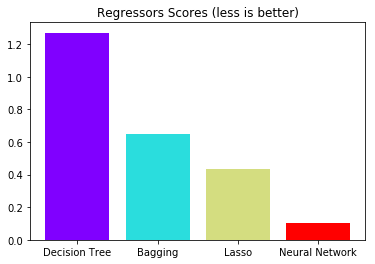

In [10]:
y_DecisionTree = DecisionTree_regr.predict(Xt)
y_Bagging = Bagging_regr.predict(Xt)
y_Lasso = Lasso_regr.predict(Xt)
y_NeuralNetwork = NeuralNetwork_regr.predict(Xt)

scores = {
  "Decision Tree": DecisionTree_regr.score(Xt,yt),
  "Bagging": Bagging_regr.score(Xt,yt),
  "Lasso": Lasso_regr.score(Xt,yt),
  "Neural Network": NeuralNetwork_regr.score(Xt,yt),
}

values = - np.array(list(scores.values()))
keys = list(scores.keys())
colors = ['#624ea7', 'g', 'yellow', 'k', 'maroon']
plt.bar(range(len(scores)), values, align='center',color=cm.rainbow(np.linspace(0, 1, len(scores))))
plt.xticks(range(len(scores)), keys)
plt.title("Regressors Scores (less is better)")
plt.figure()

In [11]:
y_DecisionTree = DecisionTree_regr.predict(Xt)
y_Bagging = Bagging_regr.predict(Xt)
y_Lasso = Lasso_regr.predict(Xt)
y_NeuralNetwork = NeuralNetwork_regr.predict(Xt)

Y = {
  "GT":yt,
  "DecisionTree":y_DecisionTree,
  "Bagging":y_Bagging,
  "Lasso":y_Lasso,
  "NeuralNetwork":y_NeuralNetwork,
}

interact(Y_ploter,Range=RangeSlider,Y=fixed(Y))

interactive(children=(IntRangeSlider(value=(8311, 8391), continuous_update=False, description='Test:', layout=Layout(height='50px', width='90%'), max=13096, min=1, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.Y_ploter>

In [12]:
Xs = [scaler(yt),
      #X['s3'],X['a3'],X['sd3'],
      #X['s4'],X['a4'],X['sd4'],
      X['s3'],
      X['s4'],
      X['s6'],
      X['s7'],
      X['s8'],
      X['s9'],
      X['s11'],
      X['s12'],
      X['s13'],
      X['s14'],
      X['s15'],
      X['s16'],
      X['s17'],
     ]
interact(general_data_ploter,Range=RangeSlider,Xs=fixed(Xs),y=fixed(yt),scale_y=fixed(True))

interactive(children=(IntRangeSlider(value=(8311, 8391), continuous_update=False, description='Test:', layout=Layout(height='50px', width='90%'), max=13096, min=1, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.general_data_ploter>